# データの探索とベンチマークの作成
このチュートリアルでは、アスペクトベース評価分析のデータセットを用いて、評価分析を行う機械学習モデルを構築します。まず評価分析に用いるデータセットを探索し、理解を深めます。次に、探索したデータセットを用いて、ベースラインとなる機械学習モデルを作成します。

では、必要なPythonモジュールをインポートしましょう。

In [26]:
import os
import json
import glob

import pandas as pd
import seaborn as sns

## データセットの読み込み
今回は評判分析のデータセットとして[chABSA-dataset](https://github.com/chakki-works/chABSA-dataset)を用いることにします。chABSA-datasetは企業の有価証券報告書に対して、各文に含まれるエンティティごとに評価情報を付与したデータセットです。[こちら](http://cloud.storage.com/chakki/public/datasets/chABSA-dataset.zip)からダウンロードして、`data`ディレクトリに展開してください。

データセットを探索して、理解を深めましょう。そのために、ダウンロードしたデータセットを読み込みます。

In [27]:
documents = []

json_files = glob.glob('./data/chABSA-dataset/*.json')
for json_file in json_files:
    with open(json_file) as f:
        documents.append(json.load(f))
        
documents[0]

{'header': {'category17': '食品',
  'category33': '水産・農林業',
  'doc_text': '有価証券報告書',
  'document_id': 'E00008',
  'document_name': 'ホクト株式会社',
  'edi_id': 'E00008',
  'scale': '6',
  'security_code': '13790'},
 'sentences': [{'opinions': [{'category': 'NULL#general',
     'from': 11,
     'polarity': 'neutral',
     'target': 'わが国経済',
     'to': 16},
    {'category': 'NULL#general',
     'from': 38,
     'polarity': 'positive',
     'target': '企業業績',
     'to': 42},
    {'category': 'NULL#general',
     'from': 43,
     'polarity': 'positive',
     'target': '雇用',
     'to': 45},
    {'category': 'NULL#general',
     'from': 46,
     'polarity': 'positive',
     'target': '所得環境',
     'to': 50},
    {'category': 'NULL#general',
     'from': 55,
     'polarity': 'positive',
     'target': '景気',
     'to': 57}],
   'sentence': '当連結会計年度におけるわが国経済は、政府の経済政策や日銀の金融緩和策により、企業業績、雇用・所得環境は改善し、景気も緩やかな回復基調のうちに推移いたしましたが、中国をはじめとするアジア新興国経済の減速懸念や、英国の欧州連合（ＥＵ）離脱決定、米国新政権への移行など、引き続き先行きは不透明な状況となっております',
   'sent

上記のコードを実行すると、ダウンロードしたデータを読み込み、そのうちの一件を表示します。一件のデータは一つの有価証券報告書を表しています。有価証券報告書を文単位に分解したものが`sentences`の中に入っています。各文には複数のエンティティが含まれています。`opinions`の中に、文内に含まれるエンティティ(`target`)、属性(`category`)、評価(`polarity`)が含まれています。**評価が文単位ではなく、エンティティ単位でついていることに注意してください。**

各項目に関する定義は[アノテーション定義書]()を御覧ください。

このチュートリアルでは各文に対してその評価を予測します。しかし、データセットでは文単位の評価はアノテーションされていません。ここでは文単位の評価を得るために、文中に含まれる各エンティティに対する評価の和が`0`より大きかったら`positive`、`0`より小さかったら`negative`となるようにデータセットを変換します。

In [28]:
def get_dataset_for_analysis(documents):
        dataset = {'label': [], 'category': [], 'sent': []}
        for d in documents:
            
            conv = {'negative': -1, 'positive': 1, 'neutral': 0}
            for sent in d['sentences']:
                sentiment = sum(conv[opinion['polarity']] for opinion in sent['opinions'])
                if sentiment == 0:  # neutral
                    continue
                dataset['label'].append(0 if sentiment < 0 else 1)
                dataset['category'].append(d['header']['category17'])
                dataset['sent'].append(sent['sentence'])
            
        dataset = pd.DataFrame(dataset, columns=['label', 'category', 'sent'])
        return dataset
    
dataset = get_dataset_for_analysis(documents)
dataset.head()

,label,category,sent
0,1,食品,当連結会計年度におけるわが国経済は、政府の経済政策や日銀の金融緩和策により、企業業績、雇用・...
1,0,食品,当社グループを取り巻く環境は、実質賃金が伸び悩むなか、消費者の皆様の生活防衛意識の高まりや節...
2,1,食品,以上の結果、当連結会計年度の当社グループの業績は、売上高631億19百万円（前期比3.5％増...
3,1,食品,"なお、当連結会計年度の生産量は、ブナピーを含めブナシメジ42,602ｔ（同5.5％増）、エリ..."
4,1,食品,平成27年４月の火災により生産を休止していた苫小牧第一きのこセンターが、工場を再建し、平成2...


上記の表に変換したデータを表示しました。ここで、`label`は文の評価を表しており、`sent`は評価対象の文を表しています。今回構築するベースラインの機械学習モデルの目標は、`sent`を入力した際にその`label`を予測することです。そのためにまず、データを探索し、データに対する理解を深めましょう。

## データセットの探索
データセットの探索では、データに対する理解を深めて、モデルの作成に役立てます。探索のためにPythonの`Seaborn`パッケージを使ってデータを可視化します。

まずは、評価別のデータ数を可視化してみましょう。

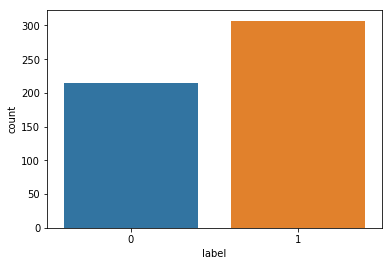

In [29]:
sns.countplot(x='label', data=dataset)

うーむ、全体的に`positive`な文が多めであるということがわかりました。

グラフをみると、`positive`な文は`negative`な文の2倍弱あることがわかります。これは、アベノミクスによる好景気が企業の業績に良い影響を与えていることや、有価証券報告書のはじめが日本の経済状況の説明から始まることが多いのが原因として考えられます。

全体的には`positive`な文が多いですが、業界別に見たらどうでしょうか？業界別に文の数と評価を可視化してみましょう。

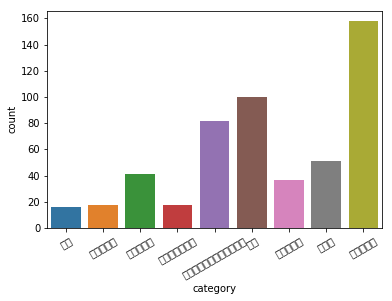

In [30]:
g = sns.countplot(x='category', data=dataset)
for item in g.get_xticklabels():
    item.set_rotation(30)

文数は業界ごとに結構差があります。そもそも、業界別の企業数が異なるのでこういう結果になるのも当然です。

では業界ごとにpositiveとnegativeの文数はどうなっているでしょうか?

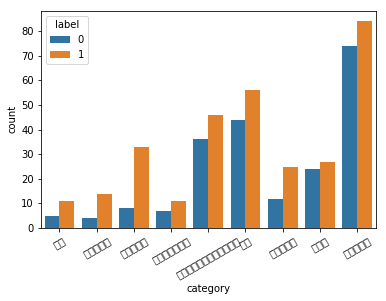

In [31]:
g = sns.countplot(x='category', hue='label', data=dataset)
for item in g.get_xticklabels():
    item.set_rotation(30)

全業界で`positive`が`negative`を上回るという結果になりました。ただ、比率は業界によって異なっています。
このような情報を利用して、業界ごとの好景気・不景気、業界間の相関(鉄鋼業界が好況だったら自動車業界も好況みたいな)を考慮したモデルを構築しても面白いかもしれませんね。

## 機械学習モデルの作成
データについての理解が深まったところで、機械学習モデルの作成に移りましょう。モデルを作成する前に、データセットを以下の3つに分割します。
* 学習用
* 検証用
* テスト用

学習用はモデルの学習に使い、検証用はハイパーパラメータチューニングに使います。テスト用はモデルの汎化性能を評価するために使います。

では、以下のようにしてデータセットを3つに分割しましょう。

In [32]:
shuffled = dataset.sample(frac=1)
trainsize = int(len(shuffled['label']) * 0.70)
validsize = int(len(shuffled['label']) * 0.15)

df_train = dataset.iloc[:trainsize, :]
df_valid = dataset.iloc[trainsize:(trainsize+validsize), :]
df_test = dataset.iloc[(trainsize+validsize):, :]

In [33]:
df_train.describe()

,label
count,364.000000
mean,0.585165
std,0.493372
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [34]:
df_valid.describe()

,label
count,78.000000
mean,0.589744
std,0.495064
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [35]:
df_test.describe()

,label
count,79.000000
mean,0.607595
std,0.491406
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


## ベンチマークの作成
複雑な機械学習モデルを作成する前に、シンプルなモデルを構築し、ベンチマークとして使いましょう。ベンチマークモデルの入力には、各文を単語列に分割し、各単語に対するTF-IDF値を計算したベクトルを使います。また、分類器にはロジスティック回帰を使います。ロジスティック回帰はシンプルながら強力なモデルであり、ベンチマークのモデルを構築する際によく使われます。評価はF1で行いましょう。

まずは、必要なPythonモジュールをインポートします。

In [36]:
from janome.tokenizer import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

次に入力の各文をTF-IDFのベクトルに変換します。入力文の分かち書きには形態素解析器`Janome`を使い、TF-IDFの計算には`TfidfVectorizer`を使うことにしましょう。

In [37]:
tokenizer = Tokenizer()
t = lambda text: tokenizer.tokenize(text, wakati=True)

vectorizer = TfidfVectorizer(tokenizer=t, analyzer='word')

X_train = vectorizer.fit_transform(df_train['sent'])
X_valid = vectorizer.transform(df_valid['sent'])
y_train = df_train['label']
y_valid = df_valid['label']

最後に、用意したデータを使って分類器に学習させましょう。分類器には`LogisticRegression`を使います。

In [38]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
y_pred = clf.predict(X_valid)
print(classification_report(y_valid, y_pred))

             precision    recall  f1-score   support

          0       0.87      0.41      0.55        32
          1       0.70      0.96      0.81        46

avg / total       0.77      0.73      0.70        78



シンプルな単語ベースのモデルでは、F1で0.70という性能になりました。

これはあまり良くない性能です。どうしたら改善できるでしょうか？

原因を探ってみましょう。まずは学習曲線を書くための関数を定義します。

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

    return plt

学習曲線を描画すると以下のようになります。

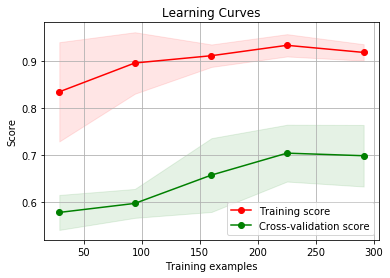

In [41]:
title = "Learning Curves"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
clf = LogisticRegression()
plot_learning_curve(clf, title, X_train, y_train, cv=cv)

plt.show()

完全に過学習しています。原因としては、データ数に対して特徴数が大きすぎることや正則化の強さが十分でないことが考えられます。実際に特徴数を表示してみましょう。特徴数を表示するためには、`vectorizer`の`get_feature_names`メソッドを呼び出します。

In [42]:
len(vectorizer.get_feature_names())

1792

正則化については、LogisticRegressionではデフォルトではL2正則化を行っていました。しかし、結果をみると正則化しているにもかかわらず、過学習をしています。この結果は正則化の強さが十分ではないことを示唆しています。

過学習を抑えるために、正則化の強さを調整しても良いのですが、今回はL2正則化の代わりに`L1`正則化を行うことにしましょう。L1正則化をすることで、特徴選択の効果が期待できます。これは実質的には単語数を削減したモデルを作成することに相当するはずです。

In [43]:
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
print(classification_report(y_valid, y_pred))

1784 / 1792


L1正則化を行うことで、性能が向上しました。では特徴選択できているのか確認してみましょう。それには、分類器の重みを確認してあげれば良さそうです。分類器の重みは、`coef_`属性の中身を見れば確認することができます。

では実際に、分類器の重みが0の個数を確認してみましょう。

In [44]:
weights = clf.coef_[0]
num_zero_weight = (weights == 0).sum()
print('{} / {}'.format(num_zero_weight, len(weights)))

1784 / 1792


結果を見ると、ほとんどの重みが0という結果になりました。では重みが0でない特徴とはどのような特徴なのでしょうか?確認してみましょう。

In [45]:
for feature, weight in zip(vectorizer.get_feature_names(), weights):
    if weight == 0:
        continue
    print(feature, weight)

し 0.824846431169468
厳しい -0.030594909991612653
回復 0.34025406578272255
堅調 0.1154609660687919
増 8.599263773498505
増加 5.768239457718046
減 -14.121307182677008
減少 -11.089972469230627


以上を見ると、`増`とか`減`といった単語が分類に大きく効いてくることがわかります。

では、最後に再び学習曲線を確認してみましょう。

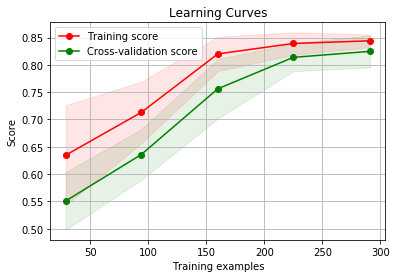

In [46]:
title = "Learning Curves"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
clf = LogisticRegression(penalty='l1')
plot_learning_curve(clf, title, X_train, y_train, cv=cv)

plt.show()

学習と検証の性能差が縮まっていることがわかります。過学習はしていませんが、少々アンダーフィット気味です。これに対しては、正則化の強さを変化させたり、より複雑なモデルを使うといった対応をすることで性能改善します。

みなさんも、自分なりの仮説を立てて性能改善に取り組んでみましょう。